# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click !here goes the icon of the corresponding button in the gutter! button.
To debug a cell, press Alt+Shift+Enter, or click !here goes the icon of the corresponding button in the gutter! button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/jupyter-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

**Point to note**
- The original dataset has no missing values

The two notes are:
G# (G sharp)
Ab (A flat)

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler


def data_clean(features_df):
    category_features = features_df.dtypes[features_df.dtypes == 'object'].index.tolist()
    encoder = OneHotEncoder(sparse_output=False)
    encoded_data = encoder.fit_transform(features_df[category_features])

    encoded_feature_names = encoder.get_feature_names_out(category_features)
    encoded_data_frame = pd.DataFrame(encoded_data, columns=encoded_feature_names)

    # combine features back together
    transformed_data = pd.concat([features_df.drop(columns=category_features), encoded_data_frame], axis=1)

    # Remove # tags from feature names
    for item in transformed_data.columns:
        if "#" in item:
            transformed_data.rename(columns={item: item.split("#/")[0] + "_sharp"}, inplace=True)

    # Remove Correlating features
    corr = transformed_data.corr()
    correlating_feature_pair_list = corr[(corr > 0.40) & (corr < 1.0)].stack().index.tolist()
    for item in range(0, len(correlating_feature_pair_list)):
        if item % 2 == 0:
            transformed_data.drop(columns=[correlating_feature_pair_list[item][0]], axis=1, inplace=True)

    return transformed_data


pd_DF = pd.read_csv('data/spotify_top_songs_audio_features.csv')
pd_DF.drop(columns=['track_name', "artist_names", "id", "source"], axis=0, inplace=True)
training_data = data_clean(pd_DF)
# print(training_data)
# sns.heatmap(cleaned_data.corr())
# sns.histplot(cleaned_data.iloc[:,:cleaned_data.columns.size -22],bins=20)
# encoded_data_frame = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

# Finding Optimum number of clusters

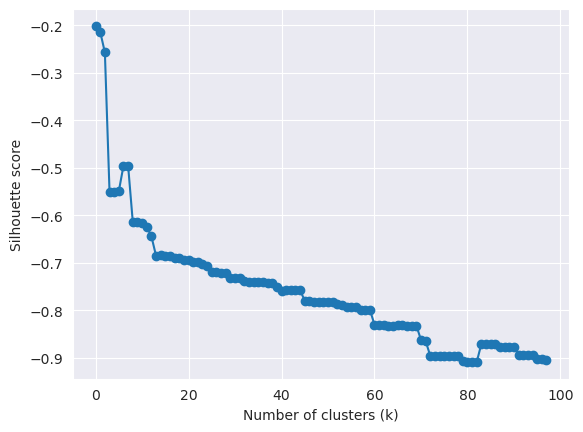

In [25]:


inertia = []
silhouettes = []
for i in list(range(1, 100)):
    pipeline = Pipeline([
        ("scaler", RobustScaler()), ("kmeans", KMeans(n_clusters=i, random_state=42))
    ])
    pipeline.fit(training_data)
    inertia.append(pipeline.named_steps['kmeans'].inertia_)
    if i != 1:
        silhouettes.append(silhouette_score(training_data, pipeline.named_steps['kmeans'].labels_))
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette score')
plt.plot(silhouettes, marker='o')
# labels = pipeline.named_steps["kmeans"].labels_

# Clustering with optimum value

In [189]:
pipeline = Pipeline([
    ("scaler", RobustScaler()), ("kmeans", KMeans(n_clusters=14, random_state=42))
])
pipeline.fit(data_pre_transformation)
print(silhouette_score(data_pre_transformation, pipeline.named_steps['kmeans'].labels_))

-0.15292552308240273
